# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00


Импорт необходимых библиотек

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [9]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [10]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [11]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]

        train_sample = {"text": tokenized_sentence, "label": self.data[idx]['label']}

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {'input_ids': sequences, 'label': labels}

    return new_batch

In [12]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [13]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

## Simple RNN

In [10]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

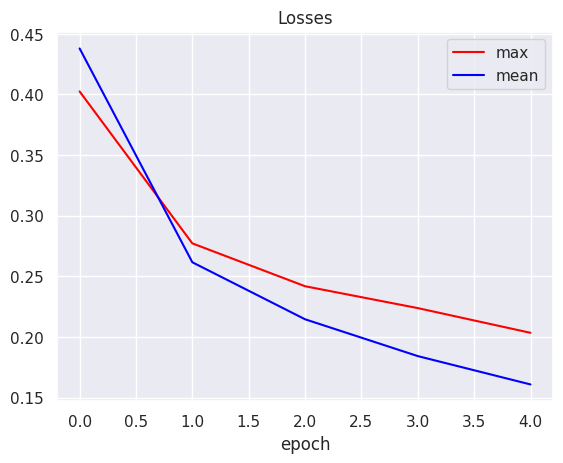

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.28
Лучшая accuracy для подхода mean: 90.90


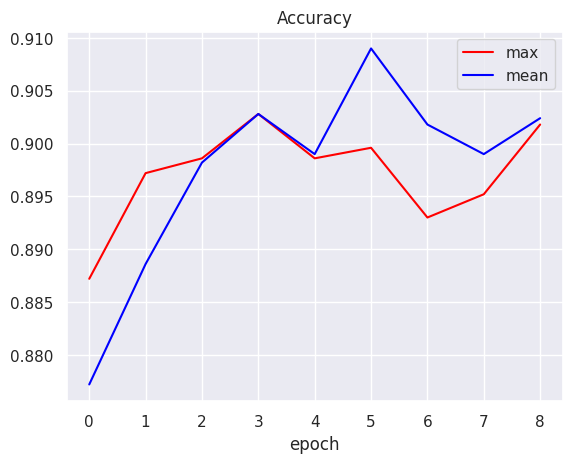

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# GRU and LSTM

In [14]:
class GRUNet(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim : int = 256, output_dim : int = 4, n_layers : int = 1, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0)
        out = out.mean(dim=1)
        out = self.fc(out)
        return out

In [15]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size: int, hidden_dim : int = 256, output_dim : int = 4, n_layers : int = 1, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device=device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device=device)

        out, _ = self.lstm(x,(h0, c0))
        out = out.mean(dim=1)
        out = self.fc(out)
        return out

In [16]:
def train(model, train_dataloader, epochs=5):
    eval_steps = len(train_dataloader) // 2

    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    acc = []
    model.train()
    epoch_times = []

    for epoch in range(epochs):
        epoch_losses = []

        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}')):
            model.zero_grad()
            out = model(batch['input_ids'])
            loss = criterion(out, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return model, losses, acc

In [17]:
vocab_size=len(vocab)
vocab_size

11842

In [57]:
def evaluate_wvl(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    predictions = []
    target = []
    loss_val = 0
    loss_pe = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
            loss_pe.append(loss.item())
        loss_val = np.mean(loss_pe)

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy, loss_val

In [64]:
def train_wvl(model, train_dataloader, epochs=5):
    eval_steps = len(train_dataloader) // 2

    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    losses = []
    acc = []
    losses_val = []
    val_loss_per_epoch = []
    model.train()

    for epoch in range(epochs):
        epoch_losses = []

        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}')):
            model.zero_grad()
            out = model(batch['input_ids'])
            loss = criterion(out, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                val_acc, val_loss = (evaluate_wvl(model, eval_dataloader))
                model.train()
                acc.append(val_acc)
                val_loss_per_epoch.append(val_loss)
        losses_val.append(np.mean(val_loss_per_epoch))
        losses.append(sum(epoch_losses) / len(epoch_losses))

    return model, losses, acc, losses_val

# GRU - 1 layer

In [67]:
model_gru = GRUNet(vocab_size=vocab_size).to(device)

In [68]:
gru_model, gru_loss, gru_acc, gru_losses_val = train_wvl(model_gru, train_dataloader)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

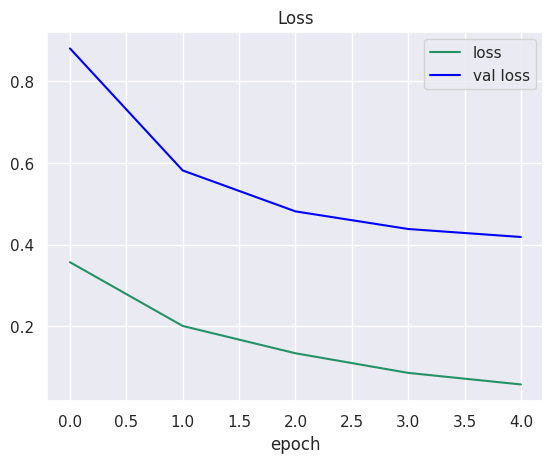

In [69]:
plt.plot(np.arange(len(gru_loss)), gru_loss, label='loss')
plt.plot(np.arange(len(gru_losses_val)), gru_losses_val, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.24


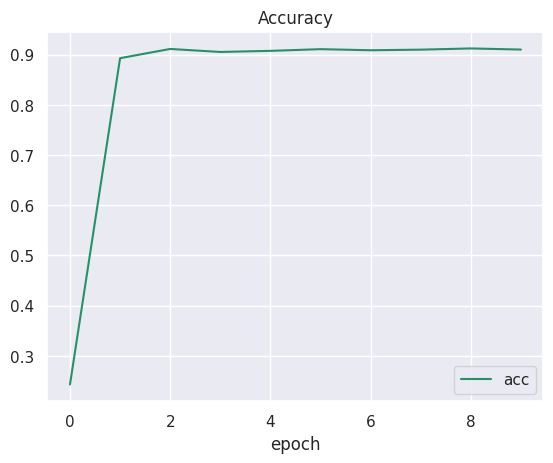

In [70]:
plt.plot(np.arange(len(gru_acc)), gru_acc, label='acc')
print(f"Лучшая accuracy: {(max(gru_acc) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [77]:
gru_acc

[0.24300000071525574,
 0.8930000066757202,
 0.9113999605178833,
 0.9053999781608582,
 0.9075999855995178,
 0.9109999537467957,
 0.9088000059127808,
 0.9099999666213989,
 0.91239994764328,
 0.9101999998092651]

# LSTM - 1 layer

In [72]:
model_lstm = GRUNet(vocab_size=vocab_size).to(device)

In [73]:
lstm_model, loss_lstm, acc_lstm, losses_val_lstm = train_wvl(model_lstm, train_dataloader, epochs=7)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

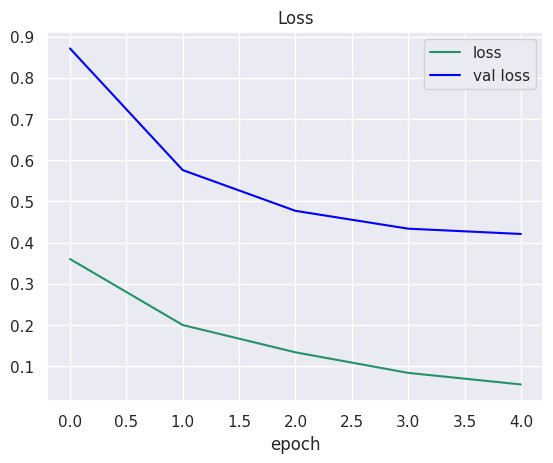

In [74]:
plt.plot(np.arange(len(loss_lstm)), loss_lstm, label='loss')
plt.plot(np.arange(len(losses_val_lstm)), losses_val_lstm, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.40


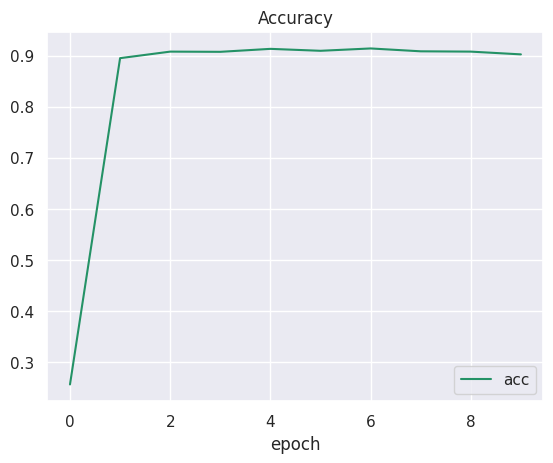

In [75]:
plt.plot(np.arange(len(acc_lstm)), acc_lstm, label='acc')
print(f"Лучшая accuracy: {(max(acc_lstm) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [76]:
acc_lstm

[0.2563999891281128,
 0.8949999809265137,
 0.9077999591827393,
 0.9073999524116516,
 0.9131999611854553,
 0.9093999862670898,
 0.9139999747276306,
 0.9083999991416931,
 0.9077999591827393,
 0.9023999571800232]

# LSTM - more epochs

In [80]:
model_me_lstm = LSTMNet(vocab_size=vocab_size).to(device)

In [81]:
lstm_me_model, loss_me_lstm, acc_me_lstm, losses_val_me_lstm = train_wvl(model_me_lstm, train_dataloader, epochs=10)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/3750 [00:00<?, ?it/s]

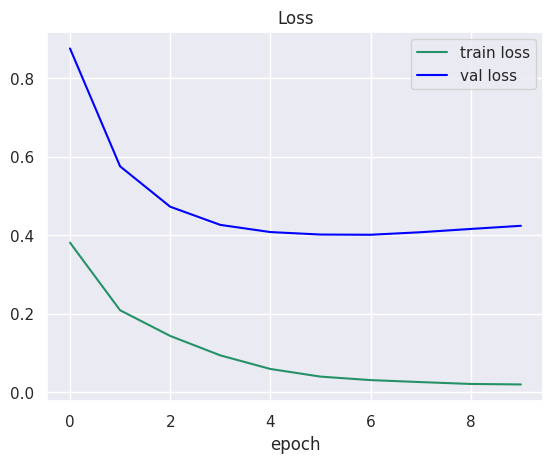

In [82]:
plt.plot(np.arange(len(loss_me_lstm)), loss_me_lstm, label='train loss')
plt.plot(np.arange(len(losses_val_me_lstm)), losses_val_me_lstm, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.70


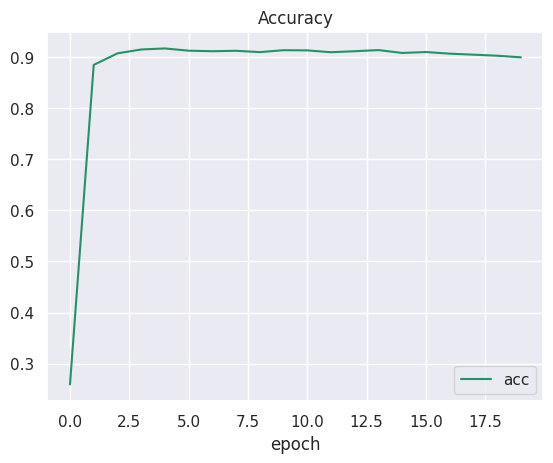

In [83]:
plt.plot(np.arange(len(acc_me_lstm)), acc_me_lstm, label='acc')
print(f"Лучшая accuracy: {(max(acc_me_lstm) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [84]:
acc_me_lstm

[0.25920000672340393,
 0.8847999572753906,
 0.9073999524116516,
 0.9149999618530273,
 0.9169999957084656,
 0.9125999808311462,
 0.9115999937057495,
 0.91239994764328,
 0.9097999930381775,
 0.913599967956543,
 0.9131999611854553,
 0.9095999598503113,
 0.9115999937057495,
 0.9138000011444092,
 0.9081999659538269,
 0.9099999666213989,
 0.9067999720573425,
 0.9047999978065491,
 0.9027999639511108,
 0.8995999693870544]

# GRU - 2 layers


In [88]:
model_gru_2l = GRUNet(vocab_size=vocab_size, n_layers=2).to(device)

In [89]:
model_gru_2l, losses_gru_2l, acc_gru_2l, losses_val_gru_2l = train_wvl(model_gru_2l, train_dataloader, epochs=6)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

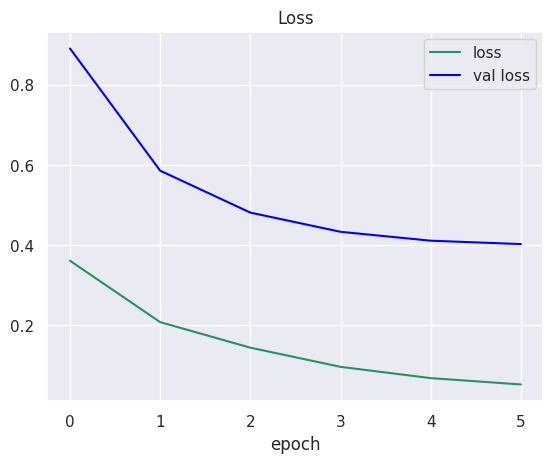

In [90]:
plt.plot(np.arange(len(losses_gru_2l)), losses_gru_2l, label='loss')
plt.plot(np.arange(len(losses_val_gru_2l)), losses_val_gru_2l, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.50


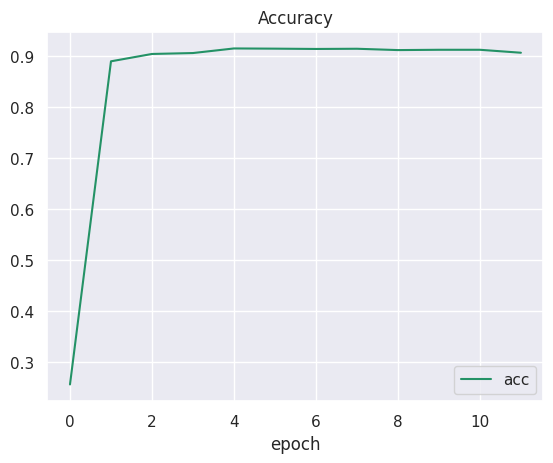

In [91]:
plt.plot(np.arange(len(acc_gru_2l)), acc_gru_2l, label='acc')
print(f"Лучшая accuracy: {(max(acc_gru_2l) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# LSTM - 2 layers

In [92]:
model_2l_lstm = LSTMNet(vocab_size=vocab_size, n_layers=2).to(device)

In [93]:
lstm_model_2l, loss_lstm_2l, acc_lstm_2l, loss_val_lstm_2l = train_wvl(model_2l_lstm, train_dataloader, epochs=6)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

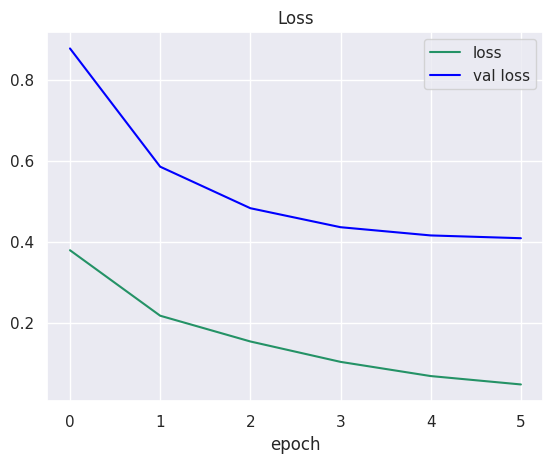

In [95]:
plt.plot(np.arange(len(loss_lstm_2l)), loss_lstm_2l, label='loss')
plt.plot(np.arange(len(loss_val_lstm_2l)), loss_val_lstm_2l, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.72


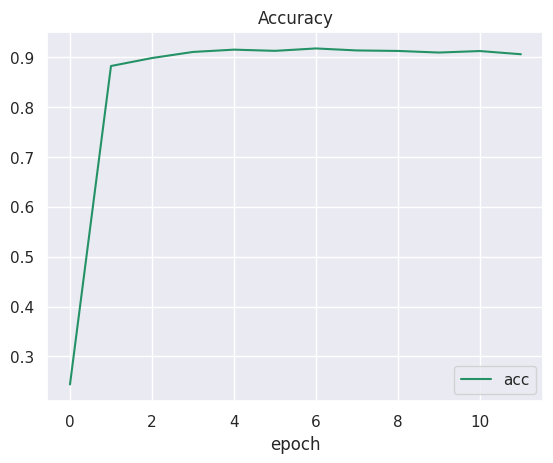

In [96]:
plt.plot(np.arange(len(acc_lstm_2l)), acc_lstm_2l, label='acc')
print(f"Лучшая accuracy: {(max(acc_lstm_2l) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# LSTM - smaller dropout rate

In [99]:
model_sd_lstm = LSTMNet(vocab_size=vocab_size, n_layers=2, drop_prob=0.1).to(device)

In [100]:
lstm_sd_model, loss_sd_lstm, acc_sd_lstm, loss_val_sd_lstm = train_wvl(model_sd_lstm, train_dataloader, epochs=6)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

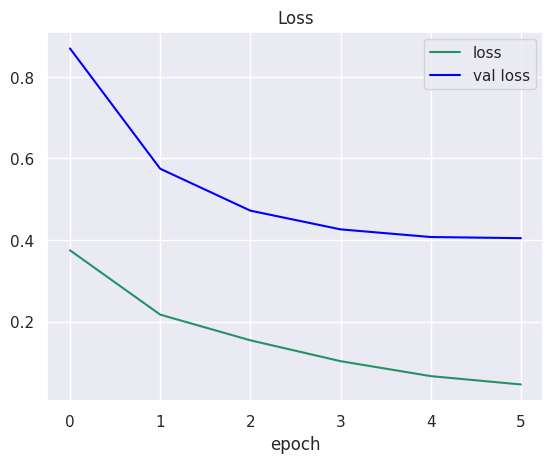

In [101]:
plt.plot(np.arange(len(loss_sd_lstm)), loss_sd_lstm, label='loss')
plt.plot(np.arange(len(loss_val_sd_lstm)), loss_val_sd_lstm, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.52


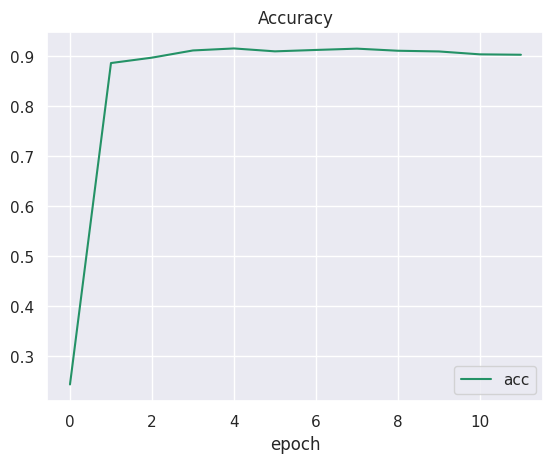

In [102]:
plt.plot(np.arange(len(acc_sd_lstm)), acc_sd_lstm, label='acc')
print(f"Лучшая accuracy: {(max(acc_sd_lstm) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# LSTM - bigger dropout rate

In [103]:
model_bd_lstm = LSTMNet(vocab_size=vocab_size, n_layers=2, drop_prob=0.3).to(device)

In [104]:
lstm_bd_model, loss_bd_lstm, acc_bd_lstm, loss_val_bd_lstm = train_wvl(model_bd_lstm, train_dataloader, epochs=6)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

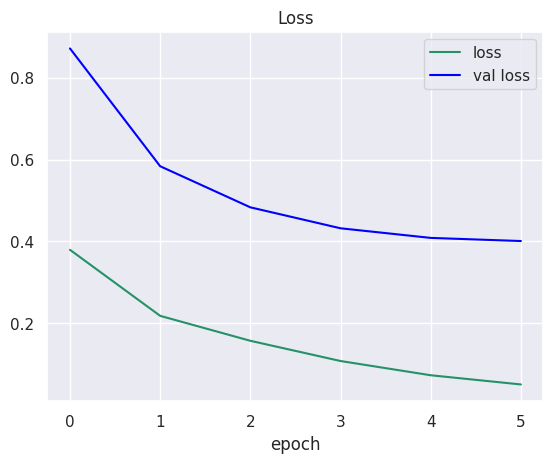

In [105]:
plt.plot(np.arange(len(loss_bd_lstm)), loss_bd_lstm, label='loss')
plt.plot(np.arange(len(loss_val_bd_lstm)), loss_val_bd_lstm, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.66


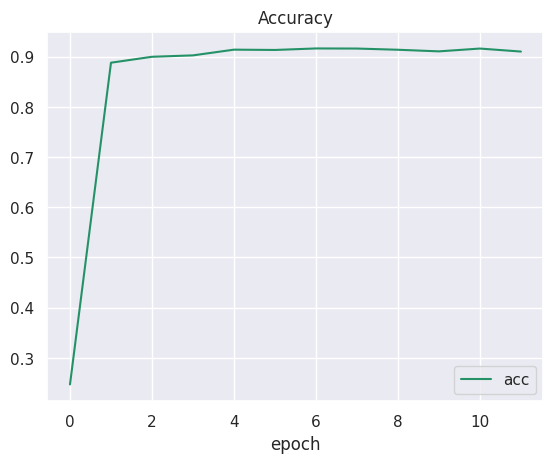

In [106]:
plt.plot(np.arange(len(acc_bd_lstm)), acc_bd_lstm, label='acc')
print(f"Лучшая accuracy: {(max(acc_bd_lstm) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# LSTM - smaller hidden dim

In [107]:
model_sh_lstm = LSTMNet(vocab_size=vocab_size, n_layers=2, hidden_dim=200).to(device)

In [108]:
lstm_sh_model, loss_sh_lstm, acc_sh_lstm, loss_val_sh_lstm = train_wvl(model_sh_lstm, train_dataloader, epochs=6)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

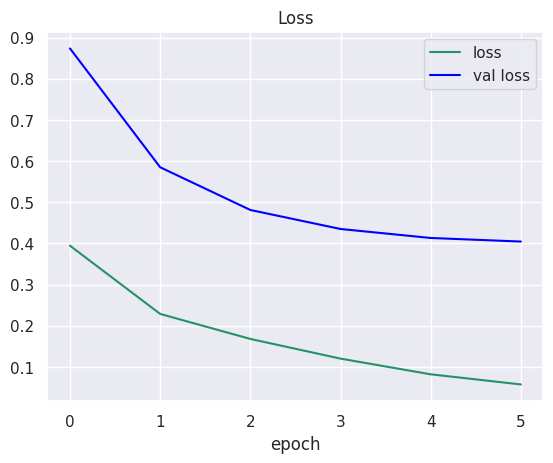

In [109]:
plt.plot(np.arange(len(loss_sh_lstm)), loss_sh_lstm, label='loss')
plt.plot(np.arange(len(loss_val_sh_lstm)), loss_val_sh_lstm, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.10


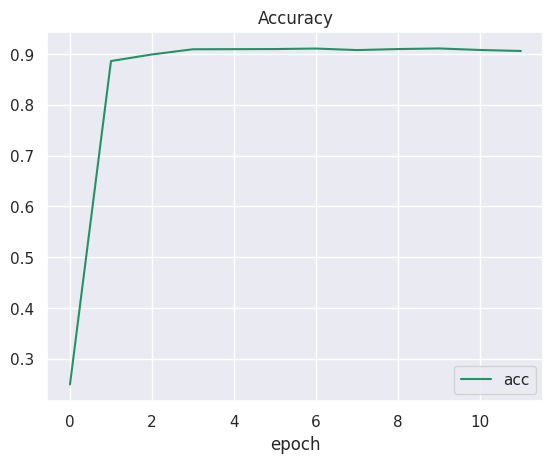

In [110]:
plt.plot(np.arange(len(acc_sh_lstm)), acc_sh_lstm, label='acc')
print(f"Лучшая accuracy: {(max(acc_sh_lstm) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# LSTM - bigger hidden dim

In [111]:
model_bh_lstm = LSTMNet(vocab_size=vocab_size, n_layers=2, hidden_dim=300).to(device)

In [112]:
lstm_bh_model, loss_bh_lstm, acc_bh_lstm, loss_val_bh_lstm = train_wvl(model_bh_lstm, train_dataloader, epochs=6)

Training epoch 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

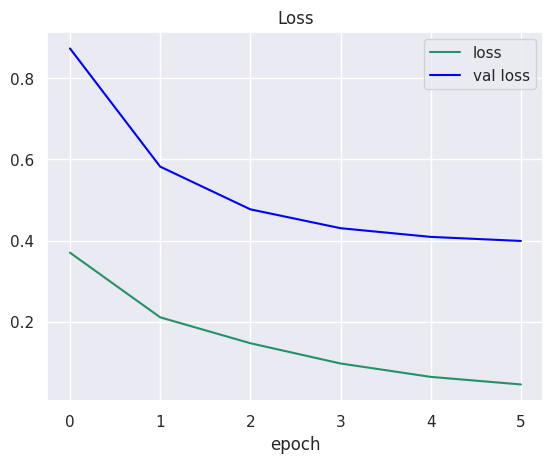

In [113]:
plt.plot(np.arange(len(loss_bh_lstm)), loss_bh_lstm, label='loss')
plt.plot(np.arange(len(loss_val_bh_lstm)), loss_val_bh_lstm, color='blue', label='val loss')
plt.title('Loss')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy: 91.80


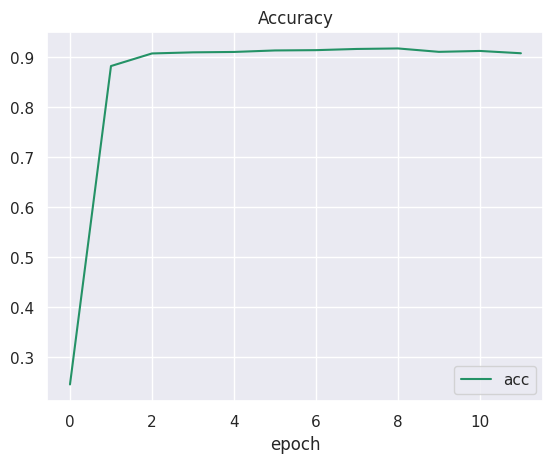

In [114]:
plt.plot(np.arange(len(acc_bh_lstm)), acc_bh_lstm, label='acc')
print(f"Лучшая accuracy: {(max(acc_bh_lstm) * 100):.2f}")
plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# Вывод:
Были получены следующие результаты обучения:

GRU 1 layer - 91.24

LSTM 1 layer - 91.40

LSTM more epochs - 91.70

GRU 2 layers - 91.50

LSTM 2 layers - 91.72

LSTM smaller dropout rate - 91.52

LSTM bigger dropout rate - 91.66

LSTM smaller hidden dim - 91.10

LSTM bigger hidden dim - 91.80.

Можно сделать вывод, что наилучшую точность на валидационной выборке дает архитектура LSTM, переобучаться модель начинает после 6-ой эпохи. Уменьшение размерности скрытого слоя и уменьшение коэффициента dropout'а дает падение точности классификации. Увеличение числа слоев LSTM также дает увеличение процента точности. Увеличение размерности скрытого слоя - поднимает точность, также как и увеличение коэффициента dropout'а. Наивысшая точность, которая составляет 91.80%, достигнута была после изменения размерности скрытого слоя LSTM до 300. Стоит отметить, что в целом лучшее качество классификации получается у LSTM по сравнению с GRU. Стабильности по качеству обучения на одинаковом числе эпох нет, это обусловленно случайным заданием весов внутри LSTM и GRU.